In [58]:
import os
os.listdir('/kaggle/input')
embeddings_path = "/kaggle/input/embeddings"
print(os.listdir(embeddings_path))

['speeches_with_embeddings.csv', 'speeches_embeddings_sentiment.csv', 'news_embeddings_sentiment.csv', 'news_with_embeddings.csv']


# Similarity algorithm efficiently 

In [59]:
import pandas as pd

speeches_embeddings = pd.read_csv(f"{embeddings_path}/speeches_with_embeddings.csv")
news_embeddings = pd.read_csv(f"{embeddings_path}/news_with_embeddings.csv")

# Display first few rows
print("News Data:")
print(news_embeddings.head())

print("\nSpeeches Data:")
print(speeches_embeddings.head())

News Data:
          Index                                               Link  \
0  1_01_12_2018  https://www.bbc.com/mundo/noticias-america-lat...   
1  2_01_12_2018  https://politica.expansion.mx/presidencia/2018...   
2  3_01_12_2018  https://oem.com.mx/elsoldemexico/mexico/en-don...   
3  4_01_12_2018  https://politica.expansion.mx/presidencia/2018...   
4  5_01_12_2018  https://www.eleconomista.com.mx/politica/Nicol...   

                                              Domain  \
0  BBC\nToma de protesta de AMLO: las 5 tradicion...   
1  Expansión Política\nAMLO rinde protesta y prom...   
2  El Sol de México\n¿Hay Ley Seca este 1 de dici...   
3  Expansión Política\nAMLO es un "líder persiste...   
4  El Economista\nNicolás Maduro llega a Palacio ...   

                                               Title        Date  \
0  Toma de protesta de AMLO: las 5 tradiciones qu...  2018-12-01   
1        AMLO rinde protesta y promete no reelegirse  2018-12-01   
2  ¿Hay Ley Seca este 1 de 

In [60]:
print(news_embeddings.shape) 
print(news_embeddings.columns)
print(speeches_embeddings.columns)

(42822, 10)
Index(['Index', 'Link', 'Domain', 'Title', 'Date', 'Content', 'month_abbr',
       'processed_content', 'news_chunks', 'news_embeddings'],
      dtype='object')
Index(['Unnamed: 0', 'X', 'speech_id', 'title', 'urls', 'content', 'date',
       'speech_chunks', 'speech_embeddings'],
      dtype='object')


### Steps to redo the index so we can capture time-dependencies 

In [61]:
# Step 1: Sort speeches by the date
speeches_embeddings = speeches_embeddings.sort_values(by='date', ascending=True)

# Step 2: Reset the index so that we can modify it
speeches_embeddings = speeches_embeddings.reset_index(drop=True)

# Step 3: Format the date into dd_mm_yyyy
speeches_embeddings['date_formatted'] = pd.to_datetime(speeches_embeddings['date']).dt.strftime('%d_%m_%Y')

# Step 4: Update the existing index with the new format (speech_number_dd_mm_yyyy)
speeches_embeddings.index = (speeches_embeddings.index + 1).astype(str) + '_' + speeches_embeddings['date_formatted']

# Step 5: Check the resulting DataFrame
print(speeches_embeddings[['date', 'speech_id']].head())



                    date  speech_id
1_04_12_2018  2018-12-04      18410
2_04_12_2018  2018-12-04      18410
3_04_12_2018  2018-12-04      18410
4_04_12_2018  2018-12-04      18410
5_04_12_2018  2018-12-04      18410


In [70]:
print(speeches_embeddings.columns)
print(speeches_embeddings.head())
print(news_embeddings.columns)
print(news_embeddings.head())


Index(['Unnamed: 0', 'X', 'speech_id', 'title', 'urls', 'content', 'date',
       'speech_chunks', 'speech_embeddings', 'date_formatted'],
      dtype='object')
              Unnamed: 0     X  speech_id  \
1_04_12_2018        2113  2113      18410   
2_04_12_2018        2113  2113      18410   
3_04_12_2018        2113  2113      18410   
4_04_12_2018        2113  2113      18410   
5_04_12_2018        2113  2113      18410   

                                                          title  \
1_04_12_2018  Conferencia de prensa del presidente de México...   
2_04_12_2018  Conferencia de prensa del presidente de México...   
3_04_12_2018  Conferencia de prensa del presidente de México...   
4_04_12_2018  Conferencia de prensa del presidente de México...   
5_04_12_2018  Conferencia de prensa del presidente de México...   

                                                           urls  \
1_04_12_2018  https://lopezobrador.org.mx/2018/12/04/confere...   
2_04_12_2018  https://lopezobra

In [78]:
# Convert date columns to datetime if not already
news_embeddings['Date'] = pd.to_datetime(news_embeddings['Date'])
speeches_embeddings['date'] = pd.to_datetime(speeches_embeddings['date'])

# Filter news to only include dates from the first speech date onward
first_speech_date = speeches_embeddings['date'].min()
news_embeddings = news_embeddings[news_embeddings['Date'] >= first_speech_date]

# Re-check alignment
print(news_embeddings['Date'].min(), speeches_embeddings['date'].min())


2018-12-04 00:00:00 2018-12-04 00:00:00


### Idea: do PCA for embeddings so I have around 90% of information in three dimensions instead of 768. 

In [71]:
import numpy as np

# Function to clean and convert the embeddings with indices
def clean_and_convert_with_index(embedding_str, index):
    cleaned_str = embedding_str.replace('[', '').replace(']', '').replace('\n', '')
    embedding = np.array(cleaned_str.split()).astype(float)
    return np.append(embedding, index)  # Append index to embedding

In [72]:
import torch 

# Step 2: Clean and convert the embeddings for 2019 data
# Apply cleaning function and include index
cleaned_news_embeddings_2019 = [
    clean_and_convert_with_index(embedding_str, idx) 
    for embedding_str, idx in zip(news_2019_reset['news_embeddings'], news_2019_reset['news_index'])
]

cleaned_speech_embeddings_2019 = [
    clean_and_convert_with_index(embedding_str, idx) 
    for embedding_str, idx in zip(speeches_2019_reset['speech_embeddings'], speeches_2019_reset['speech_index'])
]

# Verify the cleaned embeddings
print("Cleaned news embedding (first sample) for 2019:", cleaned_news_embeddings_2019[0][:10])
print("Cleaned speech embedding (first sample) for 2019:", cleaned_speech_embeddings_2019[0][:10])


Cleaned news embedding (first sample) for 2019: [ 0.07005456  0.1598677   0.18203363 -0.11090291 -0.16807105  0.78287256
  1.24405897  0.93569004 -0.8792305   0.16990131]
Cleaned speech embedding (first sample) for 2019: [-0.72826749 -0.12458038  0.04132178 -0.16114226 -0.30300254  0.11076003
  0.35522407  0.29671001 -0.21902293  0.14100061]


In [73]:
import torch
import numpy as np

# Convert cleaned embeddings to NumPy arrays
news_matrix_2019 = np.vstack(cleaned_news_embeddings_2019)
speech_matrix_2019 = np.vstack(cleaned_speech_embeddings_2019)

# Convert NumPy arrays to PyTorch tensors and move to GPU
# Convert NumPy arrays to PyTorch tensors
news_tensor_2019 = torch.tensor(news_matrix_2019, dtype=torch.float32).cuda()
speech_tensor_2019 = torch.tensor(speech_matrix_2019, dtype=torch.float32).cuda()



In [74]:
# Check the tensors
print("News Tensor (first row with index):", news_tensor_2019[0][:10])
print("Speech Tensor (first row with index):", speech_tensor_2019[0][:10])


News Tensor (first row with index): tensor([ 0.0701,  0.1599,  0.1820, -0.1109, -0.1681,  0.7829,  1.2441,  0.9357,
        -0.8792,  0.1699], device='cuda:0')
Speech Tensor (first row with index): tensor([-0.7283, -0.1246,  0.0413, -0.1611, -0.3030,  0.1108,  0.3552,  0.2967,
        -0.2190,  0.1410], device='cuda:0')


In [75]:
# Function to append index to tensor, ensuring the same device
# Function to append string-based index to tensor, ensuring the same device
def append_index_to_tensor(embeddings, indices, device):
    # The embeddings tensor and the string indices are kept separate
    embeddings_with_index = embeddings  # Keep embeddings unchanged
    return embeddings_with_index, indices


In [76]:
news_2019_reset['formatted_news_index'] = news_2019_reset['news_index'].apply(lambda x: f"{x:02d}_{news_2019_reset['Date'].iloc[x-1].day:02d}_{news_2019_reset['Date'].iloc[x-1].month:02d}_{news_2019_reset['Date'].iloc[x-1].year}")
speeches_2019_reset['formatted_speech_index'] = speeches_2019_reset['speech_index'].apply(lambda x: f"{x:02d}_{speeches_2019_reset['date'].iloc[x-1].day:02d}_{speeches_2019_reset['date'].iloc[x-1].month:02d}_{speeches_2019_reset['date'].iloc[x-1].year}")

# Apply the function to both tensors (embeddings as tensors, indices as strings)
news_tensor_with_index_2019, news_indices_2019 = append_index_to_tensor(news_tensor_2019, news_2019_reset['formatted_news_index'], device=news_tensor_2019.device)
speech_tensor_with_index_2019, speech_indices_2019 = append_index_to_tensor(speech_tensor_2019, speeches_2019_reset['formatted_speech_index'], device=speech_tensor_2019.device)

In [77]:
# Verify the shape of the embeddings and check the first few values
print("Shape of news tensor with index:", news_tensor_with_index_2019.shape)
print("Shape of speech tensor with index:", speech_tensor_with_index_2019.shape)

# Print the first 10 values (embedding part) for each tensor
print("First 10 values of news tensor:", news_tensor_with_index_2019[0, :10].cpu().numpy())
print("First 10 values of speech tensor:", speech_tensor_with_index_2019[0, :10].cpu().numpy())

# For debugging: verify the first index value
print("First index (formatted) of news tensor:", news_indices_2019.iloc[0])  # First index string for news tensor
print("First index (formatted) of speech tensor:", speech_indices_2019.iloc[0])  # First index string for speech tensor

Shape of news tensor with index: torch.Size([3275, 769])
Shape of speech tensor with index: torch.Size([32874, 769])
First 10 values of news tensor: [ 0.07005456  0.1598677   0.18203363 -0.11090291 -0.16807105  0.78287256
  1.244059    0.93569005 -0.8792305   0.16990131]
First 10 values of speech tensor: [-0.7282675  -0.12458038  0.04132178 -0.16114226 -0.30300254  0.11076003
  0.35522407  0.29671    -0.21902293  0.14100061]
First index (formatted) of news tensor: 00_31_12_2019
First index (formatted) of speech tensor: 00_27_12_2019


# End of redoing indexes for tensors. 

In [12]:
#align tenshors by index before cosine similarity 
import torch

# Step 1: Find the common indices
common_indices = set(news_indices_2019).intersection(set(speech_indices_2019))

# Step 2: Filter the embeddings based on common indices
news_mask = [idx in common_indices for idx in news_indices_2019]
speech_mask = [idx in common_indices for idx in speech_indices_2019]

# Apply the mask to filter the tensors and indices
news_tensor_aligned = news_tensor_with_index_2019[news_mask]
speech_tensor_aligned = speech_tensor_with_index_2019[speech_mask]

news_indices_aligned = [idx for idx in news_indices_2019 if idx in common_indices]
speech_indices_aligned = [idx for idx in speech_indices_2019 if idx in common_indices]

# Step 3: Sort both tensors by index order (ensuring alignment)
sorted_indices = sorted(common_indices)  # Sorting to maintain order
news_order = [news_indices_aligned.index(idx) for idx in sorted_indices]
speech_order = [speech_indices_aligned.index(idx) for idx in sorted_indices]

news_tensor_final = news_tensor_aligned[torch.tensor(news_order, device=news_tensor_aligned.device)]
speech_tensor_final = speech_tensor_aligned[torch.tensor(speech_order, device=speech_tensor_aligned.device)]

# Convert indices back to lists in sorted order
news_indices_final = [news_indices_aligned[i] for i in news_order]
speech_indices_final = [speech_indices_aligned[i] for i in speech_order]

# Check the alignment
assert news_indices_final == speech_indices_final, "Indices are not perfectly aligned!"



In [13]:
# Convert tensors to CPU for easy inspection if running on GPU
news_tensor_final_cpu = news_tensor_final.cpu()
speech_tensor_final_cpu = speech_tensor_final.cpu()

# Print the first few indices and their corresponding embeddings
print("Aligned Indices and Tensor Values (First 5 Samples):\n")

for i in range(min(5, len(news_indices_final))):  # Print only the first 5 for readability
    print(f"Index: {news_indices_final[i]}")
    print(f"News Tensor[{i}]: {news_tensor_final_cpu[i][:10]}")  # Print first 10 values for brevity
    print(f"Speech Tensor[{i}]: {speech_tensor_final_cpu[i][:10]}")  # Print first 10 values for brevity
    print("-" * 80)


Aligned Indices and Tensor Values (First 5 Samples):

Index: 11_02_01_2019
News Tensor[0]: tensor([ 0.3706,  0.4688,  0.3824, -0.0145,  0.4612, -0.1481,  0.7754, -0.4364,
        -0.0694,  0.1512])
Speech Tensor[0]: tensor([-0.7283, -0.1246,  0.0413, -0.1611, -0.3030,  0.1108,  0.3552,  0.2967,
        -0.2190,  0.1410])
--------------------------------------------------------------------------------
Index: 12_02_01_2019
News Tensor[1]: tensor([ 0.3706,  0.4688,  0.3824, -0.0145,  0.4612, -0.1481,  0.7754, -0.4364,
        -0.0694,  0.1512])
Speech Tensor[1]: tensor([-0.7283, -0.1246,  0.0413, -0.1611, -0.3030,  0.1108,  0.3552,  0.2967,
        -0.2190,  0.1410])
--------------------------------------------------------------------------------
Index: 13_02_01_2019
News Tensor[2]: tensor([ 0.3706,  0.4688,  0.3824, -0.0145,  0.4612, -0.1481,  0.7754, -0.4364,
        -0.0694,  0.1512])
Speech Tensor[2]: tensor([-0.7283, -0.1246,  0.0413, -0.1611, -0.3030,  0.1108,  0.3552,  0.2967,
    

In [31]:
#experiment with new cosine similarity function 

import torch
import pandas as pd
import time

# Step 1: Save tensors to disk in CPU memory (if not already saved)
torch.save(news_tensor_final.cpu(), '/kaggle/working/news_tensor_final.pt')
torch.save(speech_tensor_final.cpu(), '/kaggle/working/speech_tensor_final.pt')

# Step 2: Load news tensor once, but keep it on the CPU
news_tensor_final = torch.load('/kaggle/working/news_tensor_final.pt')
speech_tensor_final = torch.load('/kaggle/working/speech_tensor_final.pt')

# Step 3: Define the chunked computation for cosine similarity
def compute_batch_cosine_similarity(embedding, batch_embeddings):
    embedding = embedding.unsqueeze(0) if embedding.dim() == 1 else embedding
    batch_embeddings = batch_embeddings / batch_embeddings.norm(dim=1, keepdim=True) #to avoid normalizing them manually in case theyre already normalized 
    embedding = embedding / embedding.norm(dim=1, keepdim=True)
    return torch.mm(batch_embeddings, embedding.T).squeeze()

def compute_similarities_in_chunks(speech_tensor, news_tensor, chunk_size=1000):
    similarities = []
    for i in range(0, len(news_tensor), chunk_size):
        chunk = news_tensor[i:i + chunk_size].cuda()  # Load only the chunk onto GPU
        cosine_sim = compute_batch_cosine_similarity(speech_tensor, chunk)
        similarities.extend(cosine_sim.cpu().tolist())
        del chunk  # Free memory
        torch.cuda.empty_cache()
    return similarities

# Step 4: Process the speech tensor in batches and save intermediate results
batch_size = 100  # Adjust batch size as needed
num_speeches = len(speech_tensor_final)
start_time = time.time()
processed_batches = 0  # Counter for batches processed

# Step 5: Use indices for tracking the news and speech tensors
for batch_start in range(0, num_speeches, batch_size):
    batch_end = min(batch_start + batch_size, num_speeches)

    # Load a batch of speech embeddings to the GPU
    speech_batch = torch.load('/kaggle/working/speech_tensor_final.pt')[batch_start:batch_end].cuda()
    
    similarities_final = []
    
    for idx, speech_embedding_final in enumerate(speech_batch):
        cosine_similarities = compute_similarities_in_chunks(speech_embedding_final, news_tensor_final)
        
        # Store results with the indices
        for news_id, sim_value in enumerate(cosine_similarities):
            similarities_final.append({
                'speech_index': speech_indices_final[batch_start + idx],  # Use the speech index
                'news_index': news_indices_final[news_id],  # Use the news index
                'cosine_similarity': sim_value
            })

    # Save intermediate results to disk with the indices included
    similarities_df_final = pd.DataFrame(similarities_final)
    similarities_df_final.to_parquet(f'/kaggle/working/similarities_final_batch_{batch_start}.parquet')
    
    # Free up GPU memory
    del speech_batch
    torch.cuda.empty_cache()
    
    # Increment and check if 1000 batches processed
    processed_batches += 1
    if processed_batches % 100 == 0:
        elapsed_time = time.time() - start_time
        print(f"Processed {processed_batches * batch_size}/{num_speeches} speeches. Elapsed time: {elapsed_time:.2f}s")

print("Finished computing cosine similarities.")


Finished computing cosine similarities.


<ipython-input-31-171fd6904888>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  news_tensor_final = torch.load('/kaggle/working/news_tensor_final.pt')
<ipython-input-31-17

In [32]:
print(similarities_df_final.columns)


Index(['speech_index', 'news_index', 'cosine_similarity'], dtype='object')


In [56]:
import pandas as pd

# Assuming similarities_df_final already contains 'speech_index', 'news_index', and 'cosine_similarity'

# Extract date from speech_index and news_index while handling the day-first warning
similarities_df_final['speech_date'] = pd.to_datetime(
    similarities_df_final['speech_index'].apply(lambda x: x.split('_')[1] + '-' + x.split('_')[2] + '-' + x.split('_')[3]),
    dayfirst=True
)

similarities_df_final['news_date'] = pd.to_datetime(
    similarities_df_final['news_index'].apply(lambda x: x.split('_')[1] + '-' + x.split('_')[2] + '-' + x.split('_')[3]),
    dayfirst=True
)

# Retain relevant columns
print(similarities_df_final.head())
print(similarities_df_final.columns.tolist())  # See exact column names
print(len(similarities_df_final['news_date']))

    speech_index     news_index  cosine_similarity speech_date  news_date
0  11_02_01_2019  11_02_01_2019           0.612830  2019-01-02 2019-01-02
1  11_02_01_2019  12_02_01_2019           0.631791  2019-01-02 2019-01-02
2  11_02_01_2019  13_02_01_2019           0.648295  2019-01-02 2019-01-02
3  11_02_01_2019  14_02_01_2019           0.662648  2019-01-02 2019-01-02
4  11_02_01_2019  15_02_01_2019           0.675128  2019-01-02 2019-01-02
['speech_index', 'news_index', 'cosine_similarity', 'speech_date', 'news_date']
1156


In [57]:
print(similarities_df_final['news_date'].nunique())  # Should be >1
print(similarities_df_final['news_date'].unique())   # See unique dates


1
<DatetimeArray>
['2019-01-02 00:00:00']
Length: 1, dtype: datetime64[ns]


In [34]:
similarities_df_final.columns = similarities_df_final.columns.str.strip() 
filtered_df = similarities_df_final  # Ensure it includes news_date
print(filtered_df.columns)

Index(['speech_index', 'news_index', 'cosine_similarity', 'speech_date',
       'news_date'],
      dtype='object')


In [53]:
print(filtered_df['news_date'].isna().sum())  # Check for missing values
print(filtered_df['news_date'].dtype)

0
datetime64[ns]


In [51]:
summary_stats = (
    filtered_df.groupby('news_date')
    .agg(avg_cosine_similarity=('cosine_similarity', 'mean'),
         max_cosine_similarity=('cosine_similarity', 'max'),
         min_cosine_similarity=('cosine_similarity', 'min'),
         num_pairs=('cosine_similarity', 'count'))
    .reset_index()
)
summary_stats['news_date'] = pd.to_datetime(summary_stats['news_date'])
print(summary_stats)

   news_date  avg_cosine_similarity  max_cosine_similarity  \
0 2019-01-02               0.841621               0.964873   

   min_cosine_similarity  num_pairs  
0                0.61283       1156  


In [52]:
print(filtered_df['news_date'].nunique())  # Number of unique dates
print(filtered_df['news_date'].unique()[:10])  # Show first 10 unique dates


1
<DatetimeArray>
['2019-01-02 00:00:00']
Length: 1, dtype: datetime64[ns]


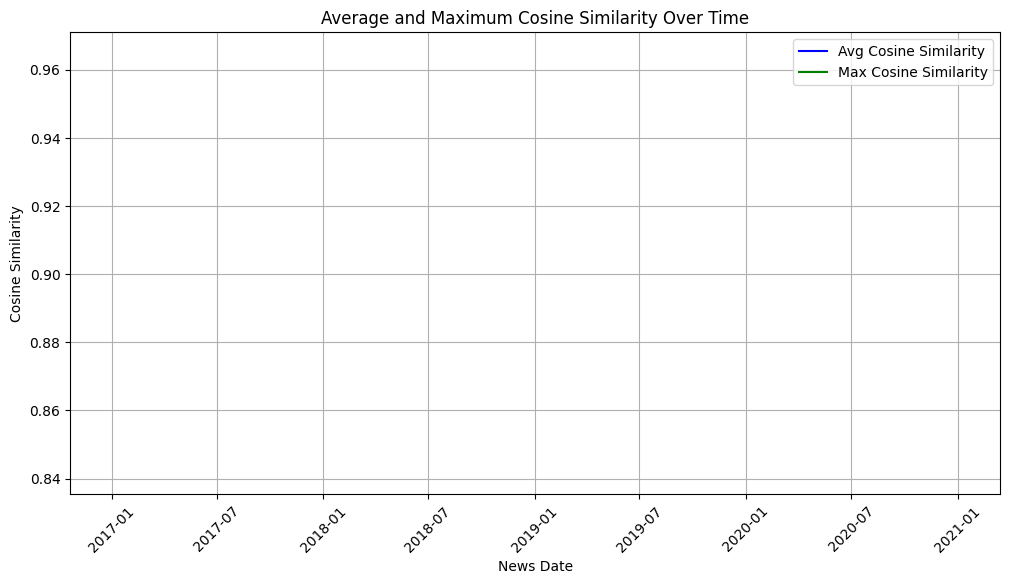

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(summary_stats['news_date'], summary_stats['avg_cosine_similarity'], label='Avg Cosine Similarity', color='b')
plt.plot(summary_stats['news_date'], summary_stats['max_cosine_similarity'], label='Max Cosine Similarity', color='g')
plt.xlabel('News Date')
plt.ylabel('Cosine Similarity')
plt.title('Average and Maximum Cosine Similarity Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Index(['speech_index', 'news_index', 'cosine_similarity', 'speech_date',
       'news_date'],
      dtype='object')
speech_index                 object
news_index                   object
cosine_similarity           float64
speech_date          datetime64[ns]
news_date            datetime64[ns]
dtype: object


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


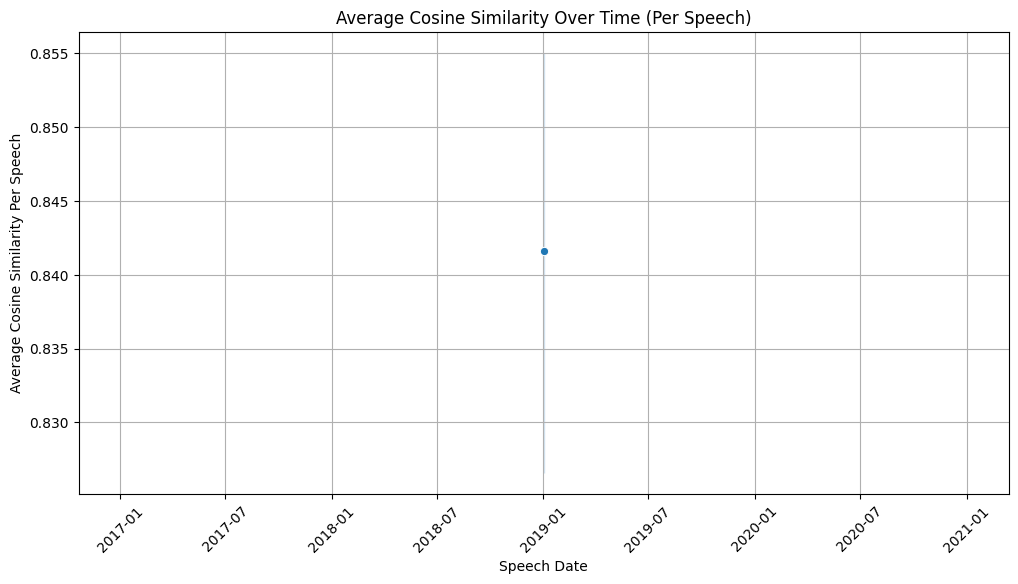

In [46]:
print(filtered_df.columns)
print(filtered_df.dtypes)

speech_summary_df = filtered_df.groupby('speech_index').agg(
    avg_cosine_similarity=('cosine_similarity', 'mean'),
    num_news_articles=('cosine_similarity', 'count')  # Number of news articles linked to the speech
).reset_index()
speech_summary_df = speech_summary_df.merge(filtered_df[['speech_index', 'speech_date']].drop_duplicates(), on='speech_index', how='left')

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(x='speech_date', y='avg_cosine_similarity', data=speech_summary_df, marker='o')
plt.xlabel("Speech Date")
plt.ylabel("Average Cosine Similarity Per Speech")
plt.title("Average Cosine Similarity Over Time (Per Speech)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()




In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure news_date is in datetime format
filtered_df['news_date'] = pd.to_datetime(filtered_df['news_date'])
plt.figure(figsize=(12, 6))
sns.lineplot(x='news_date', y='avg_cosine_similarity', data=filtered_df, marker='o')
plt.xlabel("Date")
plt.ylabel("Average Cosine Similarity")
plt.title("Average Cosine Similarity Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))
sns.lineplot(x='news_date', y='num_pairs', data=filtered_df, marker='o', color='red')
plt.xlabel("Date")
plt.ylabel("Number of Pairs")
plt.title("Number of Speech-News Pairs Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


ValueError: Could not interpret value `avg_cosine_similarity` for parameter `y`

<Figure size 1200x600 with 0 Axes>

# Code to calculate cosine similarity and tries to solve the ram issue efficiently. 

In [13]:
import torch
import pandas as pd
import time

# Step 1: Save tensors to disk in CPU memory (if not already saved)
torch.save(news_tensor_2019.cpu(), '/kaggle/working/news_tensor_2019.pt')
torch.save(speech_tensor_2019.cpu(), '/kaggle/working/speech_tensor_2019.pt')

# Step 2: Load news tensor once, but keep it on the CPU
news_tensor_2019 = torch.load('/kaggle/working/news_tensor_2019.pt')
speech_tensor_2019 = torch.load('/kaggle/working/speech_tensor_2019.pt')

# Step 3: Define the chunked computation for cosine similarity
def compute_batch_cosine_similarity(embedding, batch_embeddings):
    embedding = embedding.unsqueeze(0) if embedding.dim() == 1 else embedding
    #batch_embeddings = batch_embeddings / batch_embeddings.norm(dim=1, keepdim=True) to avoid normalizing them manually in case theyre already normalized 
    #embedding = embedding / embedding.norm(dim=1, keepdim=True)
    return torch.mm(batch_embeddings, embedding.T).squeeze()

def compute_similarities_in_chunks(speech_tensor, news_tensor, chunk_size=1000):
    similarities = []
    for i in range(0, len(news_tensor), chunk_size):
        chunk = news_tensor[i:i + chunk_size].cuda()  # Load only the chunk onto GPU
        cosine_sim = compute_batch_cosine_similarity(speech_tensor, chunk)
        similarities.extend(cosine_sim.cpu().tolist())
        del chunk  # Free memory
        torch.cuda.empty_cache()
    return similarities

# Step 4: Process the speech tensor in batches and save intermediate results
batch_size = 100  # Adjust batch size as needed
num_speeches = len(speech_tensor_2019)
start_time = time.time()
processed_batches = 0  # Counter for batches processed

# Step 5: Use indices for tracking the news and speech tensors
for batch_start in range(0, num_speeches, batch_size):
    batch_end = min(batch_start + batch_size, num_speeches)

    # Load a batch of speech embeddings to the GPU
    speech_batch = torch.load('/kaggle/working/speech_tensor_2019.pt')[batch_start:batch_end].cuda()
    
    similarities_2019 = []
    
    for idx, speech_embedding_2019 in enumerate(speech_batch):
        cosine_similarities = compute_similarities_in_chunks(speech_embedding_2019, news_tensor_2019)
        
        # Store results with the indices
        for news_id, sim_value in enumerate(cosine_similarities):
            similarities_2019.append({
                'speech_index': speech_indices_2019[batch_start + idx],  # Use the speech index
                'news_index': news_indices_2019[news_id],  # Use the news index
                'cosine_similarity': sim_value
            })

    # Save intermediate results to disk with the indices included
    similarities_df_2019 = pd.DataFrame(similarities_2019)
    similarities_df_2019.to_parquet(f'/kaggle/working/similarities_2019_batch_{batch_start}.parquet')
    
    # Free up GPU memory
    del speech_batch
    torch.cuda.empty_cache()
    
    # Increment and check if 1000 batches processed
    processed_batches += 1
    if processed_batches % 100 == 0:
        elapsed_time = time.time() - start_time
        print(f"Processed {processed_batches * batch_size}/{num_speeches} speeches. Elapsed time: {elapsed_time:.2f}s")

print("Finished computing cosine similarities.")


<ipython-input-13-dc8417548981>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  news_tensor_2019 = torch.load('/kaggle/working/news_tensor_2019.pt')
<ipython-input-13-dc84

Processed 10000/32874 speeches. Elapsed time: 213.56s
Processed 20000/32874 speeches. Elapsed time: 422.33s
Processed 30000/32874 speeches. Elapsed time: 630.76s
Finished computing cosine similarities.


In [14]:
import pandas as pd
import glob
import matplotlib.pyplot as plt 
# Step 1: Load all parquet files and combine them into one DataFrame
file_paths = glob.glob('/kaggle/working/similarities_2019_batch_*.parquet')
similarities_df_2019 = pd.concat([pd.read_parquet(f) for f in file_paths], ignore_index=True)

# Check the data after loading
print(similarities_df_2019.head())

       speech_index     news_index  cosine_similarity
0  24920_02_10_2019  00_31_12_2019           0.000007
1  24920_02_10_2019  01_01_01_2019           0.062012
2  24920_02_10_2019  02_01_01_2019           0.167969
3  24920_02_10_2019  03_01_01_2019           0.188013
4  24920_02_10_2019  04_01_01_2019           0.241170


In [ ]:
#align similarities

# Assuming similarities_df_2019 already contains the 'speech_index' and 'news_index'

import pandas as pd

# Assuming similarities_df_2019 already contains 'speech_index', 'news_index', and 'cosine_similarity'

# Step 1: Extract date from speech_index and news_index while handling the day-first warning
similarities_df_2019['speech_date'] = pd.to_datetime(similarities_df_2019['speech_index'].apply(lambda x: x.split('_')[1] + '-' + x.split('_')[2] + '-' + x.split('_')[3]), dayfirst=True)
similarities_df_2019['news_date'] = pd.to_datetime(similarities_df_2019['news_index'].apply(lambda x: x.split('_')[1] + '-' + x.split('_')[2] + '-' + x.split('_')[3]), dayfirst=True)

# Step 2: Retain the speech_date, news_date, cosine_similarity, and both indexes without aggregation
# No need to group here, just keep them all in the DataFrame
print(similarities_df_2019.head())

In [ ]:
# Group by speech_date and news_date, then aggregate cosine_similarity (e.g., mean or max)
grouped_similarities = similarities_df_2019.groupby(['speech_date', 'news_date'])['cosine_similarity'].agg(['mean', 'max', 'count']).reset_index()

# Rename columns for clarity
grouped_similarities.rename(columns={'mean': 'avg_cosine_similarity', 'max': 'max_cosine_similarity', 'count': 'num_pairs'}, inplace=True)

# Check the result
print(grouped_similarities.head())


In [ ]:
# Filter speeches that occurred on or before the news date
filtered_df = similarities_df_2019[similarities_df_2019['speech_date'] <= similarities_df_2019['news_date']]

# Sort by news_date and speech_date for easier visualization
filtered_df = filtered_df.sort_values(['news_date', 'speech_date']).reset_index(drop=True)
# Group by news_date, but keep all columns and concatenate the results
grouped_df = (
    filtered_df.groupby('news_date')
    .apply(lambda x: x.reset_index(drop=True))
    .reset_index(drop=True)
)

# Display the result
print(grouped_df.head(10))



In [ ]:
# Summary statistics grouped by news_date
summary_stats = (
    filtered_df.groupby('news_date')
    .agg(avg_cosine_similarity=('cosine_similarity', 'mean'),
         max_cosine_similarity=('cosine_similarity', 'max'),
         min_cosine_similarity=('cosine_similarity', 'min'),
         num_pairs=('cosine_similarity', 'count'))
    .reset_index()
)
print(summary_stats.head())


In [ ]:
import matplotlib.pyplot as plt

# Convert 'news_date' to datetime if it isn't already
summary_stats['news_date'] = pd.to_datetime(summary_stats['news_date'])

# Plot avg_cosine_similarity over time
plt.figure(figsize=(12, 6))
plt.plot(summary_stats['news_date'], summary_stats['avg_cosine_similarity'], label='Avg Cosine Similarity', color='b')
plt.plot(summary_stats['news_date'], summary_stats['max_cosine_similarity'], label='Max Cosine Similarity', color='g')
plt.xlabel('News Date')
plt.ylabel('Cosine Similarity')
plt.title('Average and Maximum Cosine Similarity Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot num_pairs over time
plt.figure(figsize=(12, 6))
plt.bar(summary_stats['news_date'], summary_stats['num_pairs'], color='orange', alpha=0.7)
plt.xlabel('News Date')
plt.ylabel('Number of Pairs')
plt.title('Number of Speech-News Pairs Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
import os

# Define directory to save files
save_dir = "saved_data"
os.makedirs(save_dir, exist_ok=True)

# Save as CSV
summary_stats.to_csv(os.path.join(save_dir, "summary_stats.csv"), index=False)
filtered_df.to_csv(os.path.join(save_dir, "filtered_df.csv"), index=False)
grouped_df.to_csv(os.path.join(save_dir, "grouped_similarities.csv"), index=False)


In [ ]:
import os
os.listdir('/kaggle/input')
embeddings_path = "/kaggle/input/cosine-similarity-df"
print(os.listdir(embeddings_path))

In [ ]:
import pandas as pd 

grouped_similarities = pd.read_csv(f"{embeddings_path}/grouped_similarities.csv")
filtered_df = pd.read_csv(f"{embeddings_path}/filtered_df.csv")
summary_stats = pd.read_csv(f"{embeddings_path}/summary_stats.csv")

In [ ]:
print(grouped_similarities.head())
print(filtered_df.head())
print(summary_stats.head())

In [ ]:
print(summary_stats.head())

In [ ]:
#in this section i can normalize similarity scores and consider the amount of news-speeches pairs. 
# Min-Max normalization function
#def min_max_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Normalize cosine_similarity column in grouped_similarities
#grouped_similarities["normalized_cosine_similarity"] = min_max_normalize(grouped_similarities["cosine_similarity"])

In [ ]:
from scipy.stats import zscore

# Compute Z-score normalization for cosine similarities
grouped_similarities["z_normalized_similarity"] = grouped_similarities["cosine_similarity"].transform(zscore)


In [ ]:
normalized_summary = grouped_similarities.groupby("speech_date")["z_normalized_similarity"].agg(
    avg_similarity="mean",
    max_similarity="max",
    min_similarity="min"
).reset_index()


In [ ]:
print(normalized_summary)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(normalized_summary["speech_date"], normalized_summary["avg_similarity"], label="Avg Similarity (Z-Score)", color="blue", linestyle="-")
plt.plot(normalized_summary["speech_date"], normalized_summary["max_similarity"], label="Max Similarity (Z-Score)", color="red", linestyle="--")
plt.plot(normalized_summary["speech_date"], normalized_summary["min_similarity"], label="Min Similarity (Z-Score)", color="green", linestyle=":")

plt.xlabel("Speech Date")
plt.ylabel("Z-Score Normalized Similarity")
plt.title("Normalized Similarity Trends Over Time (Z-Score)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
# Plot the normalized similarity metrics over time
plt.figure(figsize=(12, 6))

plt.plot(normalized_summary["speech_date"], normalized_summary["avg_similarity"], label="Avg Similarity", color="blue", linestyle="-")
plt.plot(normalized_summary["speech_date"], normalized_summary["max_similarity"], label="Max Similarity", color="red", linestyle="--")
plt.plot(normalized_summary["speech_date"], normalized_summary["min_similarity"], label="Min Similarity", color="green", linestyle=":")

# Formatting the plot
plt.xlabel("Speech Date")
plt.ylabel("Normalized Cosine Similarity")
plt.title("Normalized Similarity Trends Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


### The idea now, watching at the images, is that I need to build a score (similarity score or sentiment score) between speeches and news articles. The thing is that there are a lot of paragraphs similar to news articles, then it is interesting to create a measure for article similarity. Or compute another measure for articles. 
Article measure = sentiment score * similarity score 
I can do this and then see ways to improve it or change it. 


In [ ]:
#sentiment analysis 
!pip install transformers torch --quiet




In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the pre-trained SaBERT model and tokenizer
MODEL_NAME = "VerificadoProfesional/SaBERT-Spanish-Sentiment-Analysis"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


In [ ]:
def predict_sentiment(text):
    """
    Predicts sentiment for a given chunk of text using SaBERT.
    """
    if not isinstance(text, str) or len(text.strip()) == 0:
        return "Neutral"  # Handle empty cases

    # Tokenize the chunk (keeping your structure intact)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Get the model's prediction
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    
    return "Positive" if predicted_class == 1 else "Negative"


In [ ]:
import time
from tqdm import tqdm  # For progress bar

# Define the prediction function with time and progress tracking
def predict_sentiment(text, start_time, processed_count, total_chunks):
    """
    Predicts sentiment for a given chunk of text using SaBERT.
    Also tracks time taken for each batch of 1000 processed chunks.
    """
    if not isinstance(text, str) or len(text.strip()) == 0:
        return "Neutral"  # Handle empty cases

    # Tokenize the chunk (keeping your structure intact)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Get the model's prediction
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    
    sentiment = "Positive" if predicted_class == 1 else "Negative"

    # Update progress and time estimation every 1000 chunks
    processed_count += 1
    if processed_count % 10000 == 0 or processed_count == total_chunks:
        elapsed_time = time.time() - start_time
        time_per_batch = elapsed_time / processed_count
        estimated_time_left = (total_chunks - processed_count) * time_per_batch
        print(f"Processed {processed_count}/{total_chunks} chunks.")
        print(f"Elapsed Time: {elapsed_time:.2f} seconds.")
        print(f"Estimated Time Left: {estimated_time_left:.2f} seconds.")
        print(f"Time per 1000 Chunks: {time_per_batch * 1000:.2f} seconds.")
    
    return sentiment, processed_count


# Function to process chunks with time updates and estimations
def process_with_time_estimation(df, chunk_column, sentiment_column):
    """
    Processes the chunks of text, applies sentiment analysis, 
    and tracks time for every 1000 processed batches.
    """
    start_time = time.time()  # Start timer for the entire process
    total_chunks = len(df)  # Total number of chunks to process
    processed_count = 0  # Counter for processed chunks

    # Using tqdm for progress bar
    for idx, row in tqdm(df.iterrows(), total=total_chunks, desc="Processing Chunks"):
        # Apply sentiment analysis with time updates
        sentiment, processed_count = predict_sentiment(row[chunk_column], start_time, processed_count, total_chunks)
        df.at[idx, sentiment_column] = sentiment

    # Final message after processing
    total_elapsed_time = time.time() - start_time
    print(f"\nProcessing complete! Total time: {total_elapsed_time:.2f} seconds.")
    return df


In [ ]:
# Applying sentiment analysis to speech_chunks
speeches_embeddings = process_with_time_estimation(speeches_embeddings, 'speech_chunks', 'speech_sentiment')


In [ ]:
print(speeches_embeddings.head())

In [ ]:
speeches_embeddings.to_csv(os.path.join(save_dir, "speeches_embeddings_sentiment.csv"), index=False)

In [ ]:
import time
from tqdm import tqdm

def predict_sentiment(text):
    """
    Predicts sentiment for a given chunk of text using SaBERT.
    """
    if not isinstance(text, str) or len(text.strip()) == 0:
        return "Neutral"  # Handle empty cases

    # Tokenize the chunk
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Get the model's prediction
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    
    return "Positive" if predicted_class == 1 else "Negative"

def process_news_sentiments(news_embeddings, chunk_column='news_chunks', sentiment_column='news_sentiment'):
    """
    Processes sentiment for the news dataset with progress tracking and estimated time updates.
    """
    start_time = time.time()
    total_chunks = len(news_embeddings)
    
    for idx, row in tqdm(news_embeddings.iterrows(), total=total_chunks, desc="Processing News Sentiments"):
        # Run sentiment analysis
        news_embeddings.at[idx, sentiment_column] = predict_sentiment(row[chunk_column])

        # Display time estimation every 1,000 rows
        if (idx + 1) % 1000 == 0 or (idx + 1) == total_chunks:
            elapsed_time = time.time() - start_time
            time_per_chunk = elapsed_time / (idx + 1)
            estimated_time_left = (total_chunks - (idx + 1)) * time_per_chunk
            print(f"Processed {idx + 1}/{total_chunks} chunks. Estimated Time Left: {estimated_time_left:.2f} seconds.")

    total_time = time.time() - start_time
    print(f"\nProcessing complete! Total time: {total_time:.2f} seconds.")
    return news_embeddings



In [ ]:
print(news_embeddings.columns)

In [ ]:
# Applying sentiment analysis to news_chunks
news_embeddings = process_news_sentiments(news_embeddings)


In [ ]:
news_embeddings.to_csv(os.path.join(save_dir, "news_embeddings_sentiment.csv"), index=False)

## new idea: leverage embeddings to infer topics and then use hellingber distance as a measure to capture the effect of speeches on media articles over time 

### now next steps to create the article's score based on embeddings and sentiment.  

In [ ]:
import os 
os.listdir('/kaggle/input')
embeddings_path = "/kaggle/input/embeddings"
print(os.listdir(embeddings_path))

In [ ]:
import pandas as pd
speeches_embeddings = pd.read_csv(f"{embeddings_path}/speeches_embeddings_sentiment.csv")
news_embeddings = pd.read_csv(f"{embeddings_path}/news_embeddings_sentiment.csv") 


In [ ]:
print(speeches_embeddings.head())
print(news_embeddings.head())
print(speeches_embeddings.columns)
print(news_embeddings.columns)

In [ ]:
!pip install BERTopic

In [ ]:
import ast
import re
import numpy as np

# Function to clean and convert embeddings stored as strings
def clean_and_convert(embedding_str):
    # Ensure it's a string and remove brackets, newlines, and extra spaces
    cleaned_str = embedding_str.replace('[', '').replace(']', '').replace('\n', ' ')
    return np.array(cleaned_str.split(), dtype=float)  # Convert to NumPy array of floats

# Apply function to clean both speech and news embeddings
speeches_embeddings['cleaned_speech_embeddings'] = speeches_embeddings['speech_embeddings'].apply(clean_and_convert)
news_embeddings['cleaned_news_embeddings'] = news_embeddings['news_embeddings'].apply(clean_and_convert)

# Print the first cleaned embeddings to verify
print("Cleaned Speech Embeddings (First Row):", speeches_embeddings['cleaned_speech_embeddings'].iloc[0][:10])
print("Cleaned News Embeddings (First Row):", news_embeddings['cleaned_news_embeddings'].iloc[0][:10])

In [ ]:
print(speeches_embeddings.head())
print(news_embeddings.head())
print(speeches_embeddings.columns)
print(news_embeddings.columns)


In [ ]:
# Stack embeddings into NumPy matrices
speech_matrix = np.vstack(speeches_embeddings['cleaned_speech_embeddings'].values)
news_matrix = np.vstack(news_embeddings['cleaned_news_embeddings'].values)

# Print shape to verify
print("Speech Embedding Matrix Shape:", speech_matrix.shape)
print("News Embedding Matrix Shape:", news_matrix.shape)


In [ ]:
import numpy as np
from bertopic import BERTopic

# Stack embeddings into NumPy matrices for speeches and news
speech_matrix = np.vstack(speeches_embeddings['cleaned_speech_embeddings'].values)
news_matrix = np.vstack(news_embeddings['cleaned_news_embeddings'].values)

# Print shape to verify
print("Speech Embedding Matrix Shape:", speech_matrix.shape)
print("News Embedding Matrix Shape:", news_matrix.shape)


In [ ]:
# Extract the content for speech and news for topic modeling
speech_documents = speeches_embeddings['speech_chunks'].values  # Chunks from speeches
news_documents = news_embeddings['news_chunks'].values  # Chunks from news articles


In [ ]:
# Convert speech matrix and news matrix to numpy arrays
speech_matrix = np.array(speech_matrix)
news_matrix = np.array(news_matrix)

In [ ]:
import numpy as np
import time
from bertopic import BERTopic

# Time the process
start_time = time.time()

# Convert speech matrix and news matrix to numpy arrays
speech_matrix = np.array(speech_matrix)
news_matrix = np.array(news_matrix)

# Initialize and fit BERTopic model on speech data
speech_topic_model = BERTopic(language="spanish")
speech_topics, _ = speech_topic_model.fit_transform(speech_documents, embeddings=speech_matrix)

# Store topics in speeches_embeddings DataFrame
speeches_embeddings["speech_topics"] = speech_topics

# Get the total number of speech topics
num_speech_topics = len(set(speech_topics)) - (1 if -1 in speech_topics else 0)

# Initialize and fit BERTopic model on news data
news_topic_model = BERTopic(language="spanish")
news_topics, _ = news_topic_model.fit_transform(news_documents, embeddings=news_matrix)

# Store topics in news_embeddings DataFrame
news_embeddings["news_topics"] = news_topics

# Get the total number of news topics
num_news_topics = len(set(news_topics)) - (1 if -1 in news_topics else 0)

# Print only the final topic counts
print(f"Total speech topics: {num_speech_topics}")
print(f"Total news topics: {num_news_topics}")

# Print the time taken for the whole process
end_time = time.time()
print(f"Time taken for topic modeling: {end_time - start_time:.2f} seconds")



### I'm starting the time analysis 

In [ ]:
import numpy as np
def hellinger(p, q):
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))



In [ ]:
import numpy as np
import pandas as pd
from collections import Counter

# Define Hellinger Distance manually
def hellinger(p, q):
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))

# Convert dates to datetime format
speeches_embeddings['date'] = pd.to_datetime(speeches_embeddings['date'])
news_embeddings['Date'] = pd.to_datetime(news_embeddings['Date'])

# Define the time window (e.g., 3 days before and 3 days after)
time_window = 1


In [ ]:
# Store results
hellinger_results = []

# Iterate over each speech
for index, speech_row in speeches_embeddings.iterrows():
    speech_date = speech_row['date']
    
    # Get news before the speech (e.g., 3 days before)
    news_before = news_embeddings[
        (news_embeddings['Date'] >= (speech_date - pd.Timedelta(days=time_window))) &
        (news_embeddings['Date'] < speech_date)
    ]
    
    # Get news after the speech (e.g., 3 days after)
    news_after = news_embeddings[
        (news_embeddings['Date'] > speech_date) &
        (news_embeddings['Date'] <= (speech_date + pd.Timedelta(days=time_window)))
    ]
    
    # Skip if not enough news data exists
    if len(news_before) < 5 or len(news_after) < 5:
        continue

    # Count topic occurrences before and after
    topics_before = Counter(news_before['news_topics'])
    topics_after = Counter(news_after['news_topics'])

    # Convert to probability distributions (normalized frequency of topics)
    all_topics = list(set(topics_before.keys()) | set(topics_after.keys()))
    
    prob_before = np.array([topics_before.get(topic, 0) for topic in all_topics], dtype=float)
    prob_after = np.array([topics_after.get(topic, 0) for topic in all_topics], dtype=float)
    
    # Normalize to make them probability distributions
    prob_before /= prob_before.sum()
    prob_after /= prob_after.sum()

    # Compute Hellinger Distance
    distance = hellinger(prob_before, prob_after)
    
    # Store results
    hellinger_results.append({
        'speech_id': speech_row['speech_id'],
        'speech_date': speech_date,
        'hellinger_distance': distance
    })

# Convert to DataFrame for analysis
hellinger_df = pd.DataFrame(hellinger_results)

# Print the first few results
print(hellinger_df.head())


In [ ]:
# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hellinger_df['speech_date'], hellinger_df['hellinger_distance'], marker='o', linestyle='-')
plt.xlabel("Speech Date")
plt.ylabel("Hellinger Distance (Topic Change)")
plt.title("Effect of Speeches on News Coverage Over Time")
plt.xticks(rotation=45)
plt.show()

### Unified BERTopics 

In [ ]:
from bertopic import BERTopic
import pandas as pd

# Merge speech and news data
combined_texts = list(speeches_embeddings['speech_chunks']) + list(news_embeddings['news_chunks'])
combined_dates = list(speeches_embeddings['date']) + list(news_embeddings['Date'])

# Fit BERTopic on combined data
topic_model = BERTopic(nr_topics=100)
topics, probs = topic_model.fit_transform(combined_texts)

# Assign topics back to each dataset
num_speeches = len(speeches_embeddings)
speeches_embeddings['topic'] = topics[:num_speeches]
news_embeddings['topic'] = topics[num_speeches:]

# Store topic information
topic_info = topic_model.get_topic_info()
print(topic_info.head(10))

In [ ]:
import numpy as np
from collections import Counter

# Define Hellinger Distance function
def hellinger(p, q):
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))

# Convert dates to datetime
speeches_embeddings['date'] = pd.to_datetime(speeches_embeddings['date'])
news_embeddings['Date'] = pd.to_datetime(news_embeddings['Date'])

# Define time window (e.g., 3 days before and after)
time_window = 4 

hellinger_results = []

# Iterate over each speech
for _, speech_row in speeches_embeddings.iterrows():
    speech_date = speech_row['date']
    
    # Get news before the speech
    news_before = news_embeddings[
        (news_embeddings['Date'] >= (speech_date - pd.Timedelta(days=time_window))) &
        (news_embeddings['Date'] < speech_date)
    ]
    
    # Get news after the speech
    news_after = news_embeddings[
        (news_embeddings['Date'] > speech_date) &
        (news_embeddings['Date'] <= (speech_date + pd.Timedelta(days=time_window)))
    ]
    
    # Skip if not enough news data exists
    if len(news_before) < 5 or len(news_after) < 5:
        continue

    # Count topic occurrences before and after
    topics_before = Counter(news_before['topic'])
    topics_after = Counter(news_after['topic'])

    # Convert to probability distributions
    all_topics = list(set(topics_before.keys()) | set(topics_after.keys()))
    
    prob_before = np.array([topics_before.get(topic, 0) for topic in all_topics], dtype=float)
    prob_after = np.array([topics_after.get(topic, 0) for topic in all_topics], dtype=float)
    
    # Normalize
    prob_before /= prob_before.sum()
    prob_after /= prob_after.sum()

    # Compute Hellinger Distance
    distance = hellinger(prob_before, prob_after)
    
    # Store results
    hellinger_results.append({
        'speech_id': speech_row['speech_id'],
        'speech_date': speech_date,
        'hellinger_distance': distance
    })

# Convert to DataFrame
hellinger_df = pd.DataFrame(hellinger_results)

# Print first few results
print(hellinger_df.head())


In [ ]:
# Check column names in both dataframes
print(speeches_embeddings.columns)
print(hellinger_df.columns)


In [ ]:
# Ensure the 'date' column exists in speeches_embeddings dataframe
speeches_embeddings.rename(columns={'Date': 'date'}, inplace=True)


In [ ]:
# Rename 'speech_date' to 'date' in hellinger_df
hellinger_df.rename(columns={'speech_date': 'date'}, inplace=True)

# Now merge the dataframes
speech_impact_df = speeches_embeddings.merge(hellinger_df, on=['speech_id', 'date'])


In [ ]:
print(prob_before)
print(prob_after)


In [ ]:
#The idea here is to measure speech impact
import seaborn as sns
import matplotlib.pyplot as plt

# Merge Hellinger Distance with speech topics
speech_impact_df = speeches_embeddings.merge(hellinger_df, on=['speech_id', 'date'])

# Compute average Hellinger distance per topic
topic_impact = speech_impact_df.groupby('topic')['hellinger_distance'].mean().reset_index()
topic_impact = topic_impact.sort_values(by='hellinger_distance', ascending=False)

# Top 10 most impactful topics
print(topic_impact.head())

# Plot results
plt.figure(figsize=(12,6))
sns.barplot(data=topic_impact.head(), x='topic', y='hellinger_distance', palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Topic')
plt.ylabel('Hellinger Distance')
plt.title('Top 10 Topics with Highest News Shift After Speech')
plt.show()


In [ ]:
# Check the data type of 'speech_date'
print(speech_impact_df['speech_date'].dtype)

# Check the first few rows of 'speech_date'
print(speech_impact_df[['speech_date', 'hellinger_distance']].head())

# Ensure that 'speech_date' is in datetime format
speech_impact_df['speech_date'] = pd.to_datetime(speech_impact_df['speech_date'], errors='coerce')

# Check again if 'speech_date' is properly converted
print(speech_impact_df['speech_date'].dtype)

# Plot Hellinger Distance over time if everything looks good
plt.figure(figsize=(14, 7))
sns.lineplot(data=speech_impact_df, x='speech_date', y='hellinger_distance', marker='o', color='b', label='Hellinger Distance')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Hellinger Distance')
plt.title('Hellinger Distance Over Time (Speech Impact)')
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Merge Hellinger Distance with speech topics
speech_impact_df = speeches_embeddings.merge(hellinger_df, on=['speech_id', 'date'])

# Plot Hellinger Distance over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=speech_impact_df, x='speech_date', y='hellinger_distance', marker='o', color='b', label='Hellinger Distance')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Hellinger Distance')
plt.title('Hellinger Distance Over Time (Speech Impact)')
plt.show()

# Optional: Apply rolling average to smooth the data (if needed)
speech_impact_df['rolling_hellinger'] = speech_impact_df['hellinger_distance'].rolling(window=5).mean()

# Plot Hellinger Distance with rolling average
plt.figure(figsize=(14, 7))
sns.lineplot(data=speech_impact_df, x='speech_date', y='hellinger_distance', marker='o', color='b', label='Hellinger Distance')
sns.lineplot(data=speech_impact_df, x='speech_date', y='rolling_hellinger', color='r', label='Rolling Average (5)')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Hellinger Distance')
plt.title('Hellinger Distance Over Time with Rolling Average')
plt.legend()
plt.show()


In [ ]:
# Define sentiment mappings
sentiment_mapping = {
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1
}

# Convert speech and news sentiments to numeric values
speeches_embeddings['speech_sentiment_numeric'] = speeches_embeddings['speech_sentiment'].map(sentiment_mapping)
news_embeddings['news_sentiment_numeric'] = news_embeddings['news_sentiment'].map(sentiment_mapping)

# Now you can compute the average sentiment per topic
speech_sentiment = speeches_embeddings.groupby('topic')['speech_sentiment_numeric'].mean().reset_index()
news_sentiment = news_embeddings.groupby('topic')['news_sentiment_numeric'].mean().reset_index()

# Merge sentiment data
sentiment_df = speech_sentiment.merge(news_sentiment, on='topic', suffixes=('_speech', '_news'))

In [ ]:
print(sentiment_df.columns)


In [ ]:
# Plot sentiment shifts
plt.figure(figsize=(12, 6))
sns.scatterplot(data=sentiment_df, x='speech_sentiment_numeric', y='news_sentiment_numeric', hue='topic', palette='tab10')
plt.axhline(0, linestyle="--", color="gray")
plt.axvline(0, linestyle="--", color="gray")
plt.xlabel('Speech Sentiment')
plt.ylabel('News Sentiment')
plt.title('Sentiment Shift from Speech to News')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()


In [ ]:
from sklearn.cluster import KMeans

# Assuming 'topic_embeddings' contains the vectorized representations of the topics
kmeans = KMeans(n_clusters=10, random_state=42)  # Choose number of clusters based on your preference
sentiment_df['cluster'] = kmeans.fit_predict(topic_embeddings)

# Plotting with clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(data=sentiment_df, x='speech_sentiment_numeric', y='news_sentiment_numeric', hue='cluster', palette='tab10')
plt.axhline(0, linestyle="--", color="gray")
plt.axvline(0, linestyle="--", color="gray")
plt.xlabel('Speech Sentiment')
plt.ylabel('News Sentiment')
plt.title('Sentiment Shift by Cluster')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()


### Maybe i can also explore how to do this using spacy nlp pipeline 
But not really since they are optimized for cpu, tho i can do this test or have this in mind 


In [ ]:
import pandas as pd
from bertopic import BERTopic
from tqdm import tqdm
import time


print("Processing Speeches:")
speech_topic_model = BERTopic(language="spanish")
speech_topics = []
speech_probs = []

# Process the first batch using fit_transform (to fit the model)
first_batch_texts = speech_texts[:batch_size]
first_batch_embeds = speech_embeds[:batch_size]
batch_topics, batch_probs = speech_topic_model.fit_transform(first_batch_texts, embeddings=first_batch_embeds)
speech_topics.extend(batch_topics)
speech_probs.extend(batch_probs)
print(f"Processed {batch_size} out of {len(speech_texts)} speech chunks. Time elapsed: {time.time() - start_time:.1f} seconds.")

# Process the remaining batches using transform
for i in tqdm(range(batch_size, len(speech_texts), batch_size), desc="Speeches Batches"):
    batch_texts = speech_texts[i:i+batch_size]
    batch_embeds = speech_embeds[i:i+batch_size]
    batch_topics, batch_probs = speech_topic_model.transform(batch_texts, embeddings=batch_embeds)
    speech_topics.extend(batch_topics)
    speech_probs.extend(batch_probs)
    processed = i + len(batch_texts)
    print(f"Processed {processed} out of {len(speech_texts)} speech chunks. Time elapsed: {time.time() - start_time:.1f} seconds.")

# Add the assigned topics back into the speeches dataframe
speeches_embeddings_df["topic"] = speech_topics

######################################
# Process News Articles in Batches
######################################

print("\nProcessing News Articles:")
news_topic_model = BERTopic(language="spanish")
news_topics = []
news_probs = []

# Process the first batch using fit_transform
first_batch_texts = news_texts[:batch_size]
first_batch_embeds = news_embeds[:batch_size]
batch_topics, batch_probs = news_topic_model.fit_transform(first_batch_texts, embeddings=first_batch_embeds)
news_topics.extend(batch_topics)
news_probs.extend(batch_probs)
print(f"Processed {batch_size} out of {len(news_texts)} news chunks. Time elapsed: {time.time() - start_time:.1f} seconds.")

# Process the remaining batches using transform
for i in tqdm(range(batch_size, len(news_texts), batch_size), desc="News Batches"):
    batch_texts = news_texts[i:i+batch_size]
    batch_embeds = news_embeds[i:i+batch_size]
    batch_topics, batch_probs = news_topic_model.transform(batch_texts, embeddings=batch_embeds)
    news_topics.extend(batch_topics)
    news_probs.extend(batch_probs)
    processed = i + len(batch_texts)
    print(f"Processed {processed} out of {len(news_texts)} news chunks. Time elapsed: {time.time() - start_time:.1f} seconds.")

# Add the assigned topics back into the news dataframe
news_embeddings_df["topic"] = news_topics

######################################
# Display Sample Topic Assignments
######################################

print("\nSpeeches Topic Assignments:")
print(speeches_embeddings_df[["speech_id", "speech_chunks", "topic"]].head())

print("\nNews Topic Assignments:")
print(news_embeddings_df[["Index", "news_chunks", "topic"]].head())

### this function worked when I didnt have the information for the indices for each tensor. 
import torch
import pandas as pd
import time

# Step 1: Save tensors to disk in CPU memory
torch.save(news_tensor_2019.cpu(), '/kaggle/working/news_tensor_2019.pt')
torch.save(speech_tensor_2019.cpu(), '/kaggle/working/speech_tensor_2019.pt')

# Step 2: Load news tensor once, but keep it on the CPU
news_tensor_2019 = torch.load('/kaggle/working/news_tensor_2019.pt')

# Step 3: Define the chunked computation
def compute_batch_cosine_similarity(embedding, batch_embeddings):
    embedding = embedding.unsqueeze(0) if embedding.dim() == 1 else embedding
    batch_embeddings = batch_embeddings / batch_embeddings.norm(dim=1, keepdim=True)
    embedding = embedding / embedding.norm(dim=1, keepdim=True)
    return torch.mm(batch_embeddings, embedding.T).squeeze()

def compute_similarities_in_chunks(speech_tensor, news_tensor, chunk_size=1000):
    similarities = []
    for i in range(0, len(news_tensor), chunk_size):
        chunk = news_tensor[i:i + chunk_size].cuda()  # Load only the chunk onto GPU
        cosine_sim = compute_batch_cosine_similarity(speech_tensor, chunk)
        similarities.extend(cosine_sim.cpu().tolist())
        del chunk  # Free memory
        torch.cuda.empty_cache()
    return similarities

# Step 4: Process the speech tensor in batches and save intermediate results
batch_size = 50  # Adjust batch size as needed
num_speeches = len(speech_tensor_2019)
start_time = time.time()
processed_batches = 0  # Counter for batches processed

for batch_start in range(0, num_speeches, batch_size):
    batch_end = min(batch_start + batch_size, num_speeches)

    # Load a batch of speech embeddings to the GPU
    speech_batch = torch.load('/kaggle/working/speech_tensor_2019.pt')[batch_start:batch_end].cuda()
    
    similarities_2019 = []
    
    for idx, speech_embedding_2019 in enumerate(speech_batch):
        cosine_similarities = compute_similarities_in_chunks(speech_embedding_2019, news_tensor_2019)
        
        # Store results
        for news_id, sim_value in enumerate(cosine_similarities):
            similarities_2019.append({
                'speech_id': batch_start + idx,
                'news_id': news_id,
                'cosine_similarity': sim_value
            })

    # Save intermediate results to disk
    similarities_df_2019 = pd.DataFrame(similarities_2019)
    similarities_df_2019.to_parquet(f'/kaggle/working/similarities_2019_batch_{batch_start}.parquet')
    
    # Free up GPU memory
    del speech_batch
    torch.cuda.empty_cache()
    
    # Increment and check if 1000 batches processed
    processed_batches += 1
    if processed_batches % 1000 == 0:
        elapsed_time = time.time() - start_time
        print(f"Processed {processed_batches * batch_size}/{num_speeches} speeches. Elapsed time: {elapsed_time:.2f}s")

print("Finished computing cosine similarities.")


In [ ]:
# Combining sentiment analysis with the embeddings. But i think this doesnt make sense 
speeches_embeddings_combined = speeches_embeddings[['speech_id', 'speech_chunks', 'speech_embeddings', 'speech_sentiment']]
news_embeddings_combined = news_embeddings[['Index', 'news_chunks', 'news_embeddings', 'news_sentiment']]

# You can save this data for further analysis
speeches_embeddings_combined.to_csv("/path/to/speeches_with_sentiment.csv", index=False)
news_embeddings_combined.to_csv("/path/to/news_with_sentiment.csv", index=False)


## Save and visualize results 

In [ ]:
import pandas as pd
import glob

# Load all parquet files and combine them into one DataFrame
file_paths = glob.glob('/kaggle/working/similarities_2019_batch_*.parquet')
similarities_df_2019 = pd.concat([pd.read_parquet(f) for f in file_paths], ignore_index=True)

print(similarities_df_2019.head())


In [ ]:
print(similarities_df_2019.shape)

In [ ]:
# Group by news_id and find the maximum similarity for each news article
max_similarities = similarities_df_2019.groupby('news_id')['cosine_similarity'].max().reset_index()

# Rename the column for clarity
max_similarities.rename(columns={'cosine_similarity': 'max_cosine_similarity'}, inplace=True)

# Check the result
print(max_similarities.head())


In [ ]:
# Reset the index of news_embeddings to prepare for merging
news_embeddings_reset = news_embeddings.reset_index()

# Merge max_similarities with news_embeddings on the news_id (which corresponds to the DataFrame index)
news_with_similarity = news_embeddings_reset.merge(max_similarities, left_index=True, right_on='news_id', how='left')

# Check the merged DataFrame
print(news_with_similarity.head())


In [ ]:
import matplotlib.pyplot as plt

plt.hist(similarities_df_2019['cosine_similarity'], bins=100, edgecolor='k')
plt.title('Histogram of Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
news_with_similarity['max_cosine_similarity'].hist(bins=50)
plt.title('Distribution of Maximum Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()


### RN the main aim is to capture highly similar chunks of obrador's speeches with media articles 

In [ ]:
# Filter high-similarity pairs (cosine similarity > 0.5)
high_similarity_pairs = news_with_similarity[news_with_similarity['max_cosine_similarity'] > 0.5]

# Merge with speech metadata to get speech dates (if it's not already part of the DataFrame)
speech_metadata = pd.DataFrame({'speech_id': range(len(news_embeddings)), 'date': pd.date_range('2019-01-01', periods=len(news_embeddings))})
high_similarity_pairs = high_similarity_pairs.merge(speech_metadata, on='speech_id', how='left')

# Ensure 'date' columns are datetime
high_similarity_pairs['speech_date'] = pd.to_datetime(high_similarity_pairs['date'])
high_similarity_pairs['news_date'] = pd.to_datetime(high_similarity_pairs['Date'])  # Assuming 'Date' exists in news metadata

# Calculate time differences
high_similarity_pairs['time_diff_days'] = (high_similarity_pairs['news_date'] - high_similarity_pairs['speech_date']).dt.days

# Check the filtered DataFrame
print(high_similarity_pairs.head())



## Explore  temporal dependencies 

In [ ]:
news_with_similarity['Date'] = pd.to_datetime(news_with_similarity['Date'])
speeches_2019_reset['date'] = pd.to_datetime(speeches_2019_reset['date'])


In [ ]:
print(type(news_embeddings['news_embeddings'].iloc[0]))
#since it is a class 'str' then we need to convert the embedding as a numpy array
# Convert 'date' column to datetime if it is not already in datetime format
speeches_embeddings['date'] = pd.to_datetime(speeches_embeddings['date'], errors='coerce')
news_embeddings['Date'] = pd.to_datetime(news_embeddings['Date'], errors='coerce')


In [ ]:
def process_news_sentiments(news_embeddings, chunk_column='news_chunks', sentiment_column='news_sentiment'):
    """
    Processes sentiment for the news dataset with progress tracking and estimated time updates.
    """
    start_time = time.time()
    total_chunks = len(news_embeddings)
    
    for idx, row in tqdm(news_embeddings.iterrows(), total=total_chunks, desc="Processing News Sentiments"):
        news_embeddings.at[idx, sentiment_column] = predict_sentiment(row[chunk_column])

        if (idx + 1) % 1000 == 0 or (idx + 1) == total_chunks:
            elapsed_time = time.time() - start_time
            time_per_chunk = elapsed_time / (idx + 1)
            estimated_time_left = (total_chunks - (idx + 1)) * time_per_chunk
            print(f"Processed {idx + 1}/{total_chunks} chunks. Estimated Time Left: {estimated_time_left:.2f} seconds.")

    total_time = time.time() - start_time
    print(f"\nProcessing complete! Total time: {total_time:.2f} seconds.")
    return news_embeddings


# Code that works but eats all ram 

In [ ]:
import torch
import pandas as pd
import time

# Step 1: Save tensors to disk before loading them
torch.save(news_tensor_2019.cpu(), '/kaggle/working/news_tensor_2019.pt')
torch.save(speech_tensor_2019.cpu(), '/kaggle/working/speech_tensor_2019.pt')

# Step 2: Load tensors from disk and move them to GPU
news_tensor_2019 = torch.load('/kaggle/working/news_tensor_2019.pt').cuda()
speech_tensor_2019 = torch.load('/kaggle/working/speech_tensor_2019.pt').cuda()

# Step 3: Compute cosine similarity in chunks
def compute_batch_cosine_similarity(embedding, batch_embeddings):
    # Ensure embedding is 2D (batch_size, embedding_size)
    embedding = embedding.unsqueeze(0) if embedding.dim() == 1 else embedding
    batch_embeddings = batch_embeddings / batch_embeddings.norm(dim=1, keepdim=True)  # Normalize batch

    # Normalize the embedding (1xembedding_size)
    embedding = embedding / embedding.norm(dim=1, keepdim=True)  # Normalize single embedding
    return torch.mm(batch_embeddings, embedding.T).squeeze()  # Cosine similarity


def compute_similarities_in_chunks(speech_tensor, news_tensor, chunk_size=1000):
    similarities = []
    for i in range(0, len(news_tensor), chunk_size):
        chunk = news_tensor[i:i+chunk_size]
        cosine_sim = compute_batch_cosine_similarity(speech_tensor, chunk)
        similarities.extend(cosine_sim.cpu().tolist())
    return similarities

# Step 4: Process the tensor in chunks
similarities_2019 = []
start_time = time.time()

for idx, speech_embedding_2019 in enumerate(speech_tensor_2019):
    cosine_similarities = compute_similarities_in_chunks(speech_embedding_2019, news_tensor_2019)
    
    # Store results
    for news_id, sim_value in enumerate(cosine_similarities):
        similarities_2019.append({
            'speech_id': idx,
            'news_id': news_id,
            'cosine_similarity': sim_value
        })
        
    # Print progress
    if idx % 1000 == 0:
        elapsed_time = time.time() - start_time
        remaining_time = (elapsed_time / (idx + 1)) * (len(speech_tensor_2019) - (idx + 1))
        print(f"Processed {idx + 1}/{len(speech_tensor_2019)} speeches. ETA: {remaining_time:.2f}s")

# Step 5: Save results to disk
similarities_df_2019 = pd.DataFrame(similarities_2019)
similarities_df_2019.to_parquet('/kaggle/working/similarities_2019.parquet')

print("Finished computing cosine similarities.")